# **Classifying MEP tweets based on Political Party**
## Konstantinos Giorgas
### *Athens, 12/03/2020*


## Loading Libraries and Functions

### Libraries

In [ ]:
import tweepy
import pandas as pd
import numpy as np
from html import unescape
from sklearn import model_selection, preprocessing, tree, naive_bayes, metrics, svm, decomposition
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from scipy.stats import sem
from sklearn import svm
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist
from collections import Counter
import spacy
import matplotlib.pyplot as plt
import re
import math

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Functions

In [ ]:
def my_preprocessor(document):
  #deletes all links from corpus, replaces n't with not keeps only letters and turns all letters
  #to lowercase after translating any html character
  step1 = re.sub(r'http\S+', '', document)
  step2 = step1.replace("won't","will not").replace("n't"," not").replace("!"," exlmrk").replace("?"," qsnmrk")
  step3 = re.sub(r'[^a-zA-Z_@&]+', ' ', unescape(step2.lower()))
  step4 = ' '.join([w for w in step3.split() if len(w)>1])
  return step4

In [ ]:
def my_tokenizer(doc):
  #keeps only words that consist of more than 2 letters and exist in a predifined vocabulary
  tokens = doc.split()
  return(tokens)

In [ ]:
def getWordFreq(corpus):
  #counts and prints the frequency of each unique word in a given corpus
    result = {}
    for sentence in corpus:
        for word in sentence.split():
            if word in result:
                result[word] += 1
            else:
                result[word] = 1
    result = sorted(result.items(), key=lambda x: x[1], reverse=True)   
    return result

## Data Preprocessing


### Data Cleaning

In [ ]:
# This chunk of code is nessesary only if run in Google Colab.
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/louridas/assignment_3'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/louridas/assignment_3


In [ ]:
tweets = pd.read_csv('retweets.csv')

In [ ]:
tweets = tweets.loc[tweets.lang == 'en']

In [ ]:
tweets.shape[0]

13796

In this step I remove all the ids that belong to a group having frequency of less than 50 tweets.

In [ ]:
frequency_counts = tweets.origMepGroupShort.value_counts()
to_remove = frequency_counts[frequency_counts <= 50].index
tweets.replace(to_remove, np.nan, inplace=True)

In this step I initiate all the requested credentials for a succesfull tweeter API call.

In [ ]:
#Twitter API Authentication
consumer_key = 'consumer_key'
consumer_secret = 'consumer_secret'
access_token = 'access_token'
access_token_secret = 'access_token_secret'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In order not to violate the batch limit of tweeter API and to make the process of downloading tweets as fast as possible I downloaded the tweets based on the given tweet id in batches of 99 tweets.

In [ ]:
start, stop = 0, 0
tweet_txt = []
limit = tweets.shape[0] - 1
tweet_ids = tweets.origTweetId

while stop <= limit:
  start = stop
  stop = start + 100
  if stop > limit: stop = limit
  batch_tweets = api.statuses_lookup(id_= [x for x in tweet_ids[start:stop]])
  for tweet in batch_tweets:
      tweet_txt.append([tweet.id, tweet.text])

In [ ]:
len(tweet_txt)

10193

After removing all duplicates and dropping all `NA` values I was able to create my dataset containing of unique tweet ids and their corresponding MEP group.

In [ ]:
tweet_txt = pd.DataFrame(tweet_txt, columns = ['origTweetId', 'text'])

In [ ]:
tweet_txt = pd.merge(tweet_txt, tweets[['origTweetId', 'origMepGroupShort']],
                     how = 'left', on = 'origTweetId')

In [ ]:
tweet_txt = tweet_txt.drop_duplicates()
tweet_txt = tweet_txt.dropna()

In [ ]:
traindata = pd.DataFrame()
traindata['text'] = tweet_txt.text
traindata['label'] = tweet_txt.origMepGroupShort

### Data Exploration

I do not want any of the test set characteristics to bleed into my training dataset so at first I split the data set to train and test set as follows: 75% train data and 25% test data. I will also create a deep copy of each set since I indend to train a neural network that will require a different dataset format than traditional machine learnig practices. I will use `random_state` to make sure my results are consistent.

In [ ]:
train_X, valid_X, train_Y, valid_Y = model_selection.train_test_split(traindata.text, traindata.label, random_state = 1)
freq = train_Y.value_counts().reset_index()

In [ ]:
train_x = [x for x in train_X]
train_y = [y for y in train_Y]
valid_x = [x for x in valid_X]
valid_y = [y for y in valid_Y]

 As we can see from the distribution of the groups in our test data there is great imbalance between them

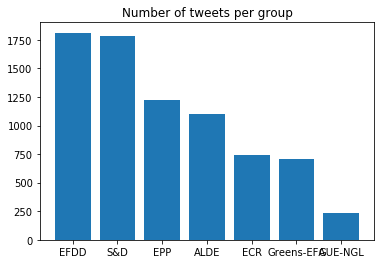

In [ ]:
plt.bar(freq['index'], freq.label)
plt.title('Number of tweets per group')
plt.show()

As expected stop words appear very often in the corpus. Also the term `EU` and the character `&amp` appear quite often as well. We will deal with them in later stages.

In [ ]:
getWordFreq([my_preprocessor(x) for x in train_x])[:100]

[('the', 4220),
 ('to', 4005),
 ('in', 2850),
 ('of', 2567),
 ('on', 2042),
 ('for', 1931),
 ('and', 1628),
 ('eu', 1579),
 ('is', 1310),
 ('with', 1177),
 ('exlmrk', 1112),
 ('not', 944),
 ('we', 939),
 ('it', 688),
 ('that', 669),
 ('at', 644),
 ('be', 628),
 ('will', 592),
 ('qsnmrk', 567),
 ('this', 565),
 ('are', 555),
 ('by', 538),
 ('from', 529),
 ('ukip', 520),
 ('today', 514),
 ('have', 477),
 ('my', 462),
 ('you', 431),
 ('europe', 430),
 ('now', 419),
 ('as', 417),
 ('european', 413),
 ('our', 413),
 ('about', 379),
 ('more', 347),
 ('all', 345),
 ('uk', 342),
 ('has', 335),
 ('no', 332),
 ('but', 332),
 ('@eppgroup', 329),
 ('people', 322),
 ('vote', 304),
 ('an', 295),
 ('great', 293),
 ('ep', 284),
 ('good', 284),
 ('do', 272),
 ('ttip', 270),
 ('must', 262),
 ('need', 261),
 ('support', 258),
 ('up', 257),
 ('meps', 254),
 ('labour', 252),
 ('new', 252),
 ('debate', 251),
 ('meeting', 248),
 ('parliament', 247),
 ('who', 242),
 ('just', 239),
 ('can', 237),
 ('what', 231

In this step I encoded the target variable to categorical labels and saved a mapping og the process.

In [ ]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [ ]:
encoder.transform(['ALDE', 'ECR', 'EFDD', 'EPP', 'GUE-NGL', 'Greens-EFA', 'S&D'])

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
labels = {0: 'ALDE', 1: 'ECR', 2:'EFDD', 3:'EPP', 4:'GUE-NGL', 5:'Greens-EFA', 6:'S&D'}

I will create a list of stopwords that appear very often in the corpus in order to be omitted.

In [ ]:
stop_words = ['to', 'the', 'in', 'of', 'on', 'for', 'and', 'a', 'an', 'be', 'with', 'eu', 'is']

## Machine Learning Models

### Decision Tree

I will use a custom preprocessor that will do the following tasks:


*   Remove any link from the tweet. (*As it appears polititians love pasting links and the tweets are full of them so no extravariance is awarded among groups*)
*   Keep only words and mentions as is. (*they may affect the contect of the tweet if tokenazed separately*)



Lets test the dataset after performing preprosessing and tokenization according to our functions

In this step I will apply a custom version of vectorizer using the custom preprocessor I initiated.

* Count Vectorizer

In [ ]:
custom_vectorizer = CountVectorizer(preprocessor=my_preprocessor,
                             #tokenizer=my_tokenizer,
                             ngram_range=(1,1),
                             stop_words = stop_words,
                            )
cv_matrix = custom_vectorizer.fit_transform(train_x)

In [ ]:
score_bin = []

As we have already observe there are imbalanced classes in the dataset. To deal with this issue I will use a weighted version of all the decision tree based algorithms I test. I will take as refference the biggest class of the dataset and give it a weight of 1. Then I will distribute the weights to the other classes according to this equation:
$$(\frac{No of Obs. In Biggest Class}{No of Obs. in n class})^{1.1} $$

In [ ]:
weights = {0: (sum(train_y==2)/sum(train_y==0))**1.1,
           1: (sum(train_y==2)/sum(train_y==1))**1.1,
           2: 1,
           3: (sum(train_y==2)/sum(train_y==3))**1.1,
           4: (sum(train_y==2)/sum(train_y==4))**1.1,
           5: (sum(train_y==2)/sum(train_y==5))**1.1,
           6: (sum(train_y==2)/sum(train_y==6))**1.1}

In [ ]:
weights

{0: 1.7281214415359492,
 1: 2.666160669510833,
 2: 1,
 3: 1.5410080589415391,
 4: 9.547342431493272,
 5: 2.7984493563686015,
 6: 1.0172780591017694}

In [ ]:
clf = tree.DecisionTreeClassifier(class_weight=weights)
clf.fit(cv_matrix, train_y)

cv_score = cross_val_score(clf, 
                           custom_vectorizer.transform(valid_x), 
                           valid_y, cv=10)
score_bin.append(['count vec tree', np.mean(cv_score)])
print(np.mean(cv_score), sem(cv_score))

0.42766020354175094 0.007506766601010574


In [ ]:
print(classification_report(valid_y, clf.predict(custom_vectorizer.transform(valid_x)),target_names = labels.values()))

              precision    recall  f1-score   support

        ALDE       0.37      0.35      0.36       355
         ECR       0.31      0.35      0.33       223
        EFDD       0.59      0.59      0.59       607
         EPP       0.50      0.54      0.52       415
     GUE-NGL       0.40      0.48      0.43        71
  Greens-EFA       0.32      0.38      0.35       242
         S&D       0.52      0.44      0.48       624

    accuracy                           0.47      2537
   macro avg       0.43      0.45      0.44      2537
weighted avg       0.47      0.47      0.47      2537



* Tfidf Vectorizer

In [ ]:
tf_vectorizer = TfidfVectorizer(preprocessor=my_preprocessor,
                             ngram_range=(1,1),
                             stop_words = stop_words,
                             )
tf_matrix = tf_vectorizer.fit_transform(train_x)

In [ ]:
clf = tree.DecisionTreeClassifier(class_weight=weights)
clf.fit(tf_matrix, train_y)

cv_score = cross_val_score(clf, 
                           tf_vectorizer.transform(valid_x), 
                           valid_y, cv=10)
print(np.mean(cv_score), sem(cv_score))

matrix_clf = confusion_matrix(valid_y, clf.predict(tf_vectorizer.transform(valid_x)))
score_bin.append(['tfidf vec tree', np.mean(cv_score)])
print(matrix_clf.diagonal()/matrix_clf.sum(axis=1))

0.40560517879929037 0.005912091569219572
[0.41971831 0.34080717 0.56672158 0.55662651 0.43661972 0.35950413
 0.42788462]


In this step I have created 2 initial decision trees (using count vectorizer and tfidf vectorizer). As we can see the accuracy of such models is very low. Let se how much ca we improve them.

In [ ]:
score_bin

[['count vec tree', 0.4662710528907712],
 ['count vec tree', 0.4599527233330051],
 ['count vec tree', 0.46484290357529795],
 ['count vec tree', 0.4648626021865458],
 ['count vec tree', 0.4683935782527332],
 ['count vec tree', 0.46205555008371907],
 ['count vec tree', 0.46767457894218456],
 ['count vec tree', 0.4712006303555599],
 ['count vec tree', 0.4655914508027184],
 ['count vec tree', 0.46209002265340293],
 ['tfidf vec tree', 0.45784004727666694]]

In order to imporve the score in this model I will put the vectorizer and the decision tree algorithm in a pipeline and performe grid search to fine tune the paramenters. The parameters that I am going to test are:  
* whether or not to use tidf or count vector
* the minimun and maximum frequency of words usied in bag of words.
* the range of ngramms

In [ ]:
count_tree = Pipeline([
    ('vect', CountVectorizer(preprocessor=my_preprocessor, stop_words=stop_words),),
     ('tfidf', TfidfTransformer()),
    ('clf', tree.DecisionTreeClassifier(class_weight=weights))
])

In [ ]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'vect__max_df':(0.5,0.7,0.9,1.0,0.3),
              'vect__min_df': (1,5,10,20)
             }

grid_count_tree = GridSearchCV(count_tree, parameters, n_jobs=-1, cv=10)    



In [ ]:
grid_count_tree.fit(train_x, train_y)

grid_count_tree.best_params_

{'tfidf__use_idf': False,
 'vect__max_df': 0.5,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2)}

In [ ]:
predicted = grid_count_tree.predict(valid_x)
score_bin.append(['grid tree', np.mean(predicted == valid_y)])
np.mean(predicted == valid_y)

0.4619629483642097

In [ ]:
print(classification_report(valid_y, predicted,target_names = labels.values()))

              precision    recall  f1-score   support

        ALDE       0.34      0.39      0.36       355
         ECR       0.32      0.35      0.33       223
        EFDD       0.64      0.58      0.61       607
         EPP       0.53      0.52      0.52       415
     GUE-NGL       0.34      0.42      0.37        71
  Greens-EFA       0.30      0.37      0.33       242
         S&D       0.50      0.43      0.46       624

    accuracy                           0.46      2537
   macro avg       0.42      0.44      0.43      2537
weighted avg       0.47      0.46      0.47      2537



As we can see the accuracy score was freatly improved from 41% to 47,4%.The best parameters model used only single words as tokens, took the words tha appear in 10% or less of the tweets and did not use tidf vectorizer. In every case it appears that the classifier performs better at predicting correctly the class od EFDD since 64% of the instances classified as EFDD were correct and was able to retrieve 58% of all the EFDD instances which as shown by support was the second largest. Generaly speaking the classifier perfomed better on classes with more representations on the dataset.

### Naive Bayes

In [ ]:
naba = MultinomialNB().fit(cv_matrix, train_y)

In [ ]:
cv_score = cross_val_score(naba, 
                           custom_vectorizer.transform(valid_x), 
                           valid_y, cv=10)
print(np.mean(cv_score), sem(cv_score))
score_bin.append(['naive bayes', np.mean(cv_score)])
matrix_naba = confusion_matrix(valid_y, naba.predict(custom_vectorizer.transform(valid_x)))
print(matrix_naba.diagonal()/matrix_naba.sum(axis=1))

0.5388285456412809 0.004348594368120479
[0.55492958 0.21524664 0.91598023 0.65301205 0.14084507 0.26033058
 0.67467949]


As we can see the naive bayes model has better accuracy scores but performed poorly on some classes mainly due to the reason that it predicted the most common labels in most cases. I will try to improve this model using gid search and them perform a more in-depth analysis. As before I will create a pipeline of my vectorisers and the model. 

In [ ]:
count_nb = Pipeline([
    ('vect', CountVectorizer(preprocessor=my_preprocessor)),
     ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB())
])

In [ ]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'vect__max_df':(0.5,1.0,0.3),
              'vect__min_df': (1,5,10,20),
              'nb__alpha': (1e-2,1e-1,1)
             }

grid_count_nb = GridSearchCV(count_nb, parameters, n_jobs=-1, cv=10) 

In [ ]:
grid_count_nb.fit(train_x, train_y)

grid_count_nb.best_params_

{'nb__alpha': 0.01,
 'tfidf__use_idf': False,
 'vect__max_df': 0.3,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1)}

In [ ]:
predicted_nb = grid_count_nb.predict(valid_x)
score_bin.append(['grid naive bayes', np.mean(predicted_nb == valid_y)])
np.mean(predicted_nb == valid_y)

0.6204178163184864

In [ ]:
print(classification_report(valid_y, predicted_nb,target_names = labels.values()))

              precision    recall  f1-score   support

        ALDE       0.56      0.58      0.57       355
         ECR       0.51      0.29      0.37       223
        EFDD       0.68      0.86      0.76       607
         EPP       0.62      0.62      0.62       415
     GUE-NGL       0.79      0.32      0.46        71
  Greens-EFA       0.58      0.35      0.44       242
         S&D       0.61      0.66      0.63       624

    accuracy                           0.62      2537
   macro avg       0.62      0.53      0.55      2537
weighted avg       0.61      0.62      0.61      2537



As it appears grid search was still able to improve the model. The optimal parameters used were:
* The vectorizer used only single words as tokens
* It used the words that appear in only the 30% of the tweets.
* It did not utilized tidf scoring on the word tokens
* The naive bayes alpha value was set to 0.1

This version of Naive Bayes algorithm was able to outperfom all previous models. On contrary to the tree based method it predincted more instances of GUE-NGL correctly but with a lower recall score. This means that it identified less tweets as GUE-NGL but the true possitives in percentage were more. EFDD still seems to be a well defined class for classification.


### Logistic Regression

In [ ]:
logreg = LogisticRegression().fit(cv_matrix, train_y)
logreg_score = cross_val_score(logreg,
                            custom_vectorizer.transform(valid_x), 
                            valid_y, 
                            cv=10)

print(np.mean(logreg_score), sem(logreg_score))
score_bin.append(['logistic regression',np.mean(logreg_score) ])
matrix_logreg = confusion_matrix(valid_y, logreg.predict(custom_vectorizer.transform(valid_x)))
print(matrix_logreg.diagonal()/matrix_logreg.sum(axis=1))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.5463290902866392 0.0038996777366599607
[0.55492958 0.40358744 0.82042834 0.60963855 0.33802817 0.41735537
 0.64423077]


In [ ]:
count_lg = Pipeline([
    ('vect', CountVectorizer(preprocessor=my_preprocessor, 
                             ngram_range = (1,1))),
     ('tfidf', TfidfTransformer(use_idf = False)),
    ('lg', LogisticRegression())
])

parameters = {'tfidf__use_idf': (True, False),
              'vect__max_df':(0.5,0.2,0.3),
              'vect__min_df': (1,2,3),
              'lg__penalty': ("l1","l2") # l1 lasso l2 ridge
             }

grid_count_lg = GridSearchCV(count_lg, parameters, n_jobs=-1, cv=10) 

grid_count_lg.fit(train_x, train_y)

print(grid_count_lg.best_params_)

{'lg__penalty': 'l2', 'tfidf__use_idf': True, 'vect__max_df': 0.2, 'vect__min_df': 1}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
predicted_lg = grid_count_lg.predict(valid_x)
score_bin.append(['grid log regression',np.mean(predicted_lg == valid_y) ])
np.mean(predicted_lg == valid_y)

0.6188411509657076

In [ ]:
print(classification_report(valid_y, predicted_lg,target_names = labels.values()))

              precision    recall  f1-score   support

        ALDE       0.57      0.55      0.56       355
         ECR       0.73      0.26      0.39       223
        EFDD       0.65      0.86      0.74       607
         EPP       0.66      0.61      0.63       415
     GUE-NGL       1.00      0.18      0.31        71
  Greens-EFA       0.64      0.31      0.42       242
         S&D       0.56      0.72      0.63       624

    accuracy                           0.62      2537
   macro avg       0.69      0.50      0.53      2537
weighted avg       0.64      0.62      0.60      2537



Using logistic regression the best perfoming predictions were in classes EFDD and EPP. It is pretty noticable that it achieved 100% precision in identifying GUE-NGL instances but wasable to retrieve only 18% of 71 of the tweets of this class.

### Support Vector Machines Classifier

In [ ]:
cvma = svm.SVC().fit(cv_matrix, train_y)
cvma_score = cross_val_score(cvma,
                            custom_vectorizer.transform(valid_x), 
                            valid_y, 
                            cv=10)

print(np.mean(cvma_score), sem(cvma_score))
matrix_cvma = confusion_matrix(valid_y, cvma.predict(custom_vectorizer.transform(valid_x)))
score_bin.append(['svm',np.mean(cvma_score)])
print(matrix_cvma.diagonal()/matrix_cvma.sum(axis=1))

0.48127042420092747 0.006853743966591
[0.45352113 0.15246637 0.84349259 0.53975904 0.08450704 0.23553719
 0.75320513]


In [ ]:
count_svm = Pipeline([
                      ('vect', CountVectorizer(preprocessor=my_preprocessor,
                                               ngram_range = (1,1))),
                      ('tfidf', TfidfTransformer()),
                      ('svm', svm.SVC())
])

parameters = [{'tfidf__use_idf': (True, False),
              'vect__max_df':(0.5,0.2,0.3),
              'vect__min_df': (1,3),
             },
              {'svm__kernel': ['rbf'], 'svm__gamma': [1e-3, 1e-4],
                     'svm__C': [1, 10, 100, 1000]},
              {'svm__kernel': ['linear'], 'svm__C': [1, 10, 100, 1000]}]
grid_count_svm = GridSearchCV(count_svm, parameters, n_jobs=-1, cv=10) 

grid_count_svm.fit(train_x, train_y)

print(grid_count_svm.best_params_)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'svm__C': 1, 'svm__kernel': 'linear'}


In [ ]:
predicted_svm = grid_count_svm.predict(valid_x)
score_bin.append(['grid svm',np.mean(predicted_svm == valid_y)])
np.mean(predicted_svm == valid_y)

0.625147812376823

In [ ]:
print(classification_report(valid_y, predicted_svm,target_names = labels.values()))

              precision    recall  f1-score   support

        ALDE       0.53      0.57      0.55       355
         ECR       0.59      0.31      0.41       223
        EFDD       0.68      0.86      0.76       607
         EPP       0.67      0.61      0.64       415
     GUE-NGL       0.81      0.31      0.45        71
  Greens-EFA       0.58      0.38      0.46       242
         S&D       0.60      0.68      0.64       624

    accuracy                           0.63      2537
   macro avg       0.64      0.53      0.56      2537
weighted avg       0.62      0.63      0.61      2537



So far SVM classifier appears to be the most suitable for our problem. It was able to predict the classes correctly for 63% of the tweets in the test set, retrieving a greater percentage of tweets in most categories. As always classes with more representations in the data set seem to be easier to predict for my models.

In the following classifiers I did not performed grid search due to resources limitation and since I already exausted the requirements of this excersize. Since I already explained in detail the classification reports of the previous models I will not go into any further detail in the following classiers.

### Baging

Although Naive Baise seems to perform slightly better on our datase still the results are far from optimal. In my quest to create a better clasifier I will utilise Bagging 

In [ ]:
bagging_clf = BaggingClassifier(tree.DecisionTreeClassifier(random_state=0, class_weight=weights), 
                                n_estimators=50, 
                                n_jobs=-1).fit(cv_matrix, train_y)
bagged_cv_score = cross_val_score(bagging_clf, 
                                  custom_vectorizer.transform(valid_x), 
                                  valid_y, 
                                  cv=5)

print(np.mean(bagged_cv_score), sem(bagged_cv_score))
matrix_bg = confusion_matrix(valid_y, bagging_clf.predict(custom_vectorizer.transform(valid_x)))
score_bin.append(['bagging trees', np.mean(bagged_cv_score)])
print(matrix_bg.diagonal()/matrix_bg.sum(axis=1))

The accuracy of the bagged model using 50 subsets of the data set is more accurate but still Naive Bayes performs better 

### Random Forests

In [ ]:
frst = RandomForestClassifier(n_estimators=50, 
                              max_depth=200,
                              min_samples_split=3, 
                              random_state=0, 
                              class_weight=weights).fit(cv_matrix, train_y)
frst_score = cross_val_score(frst, 
                                  custom_vectorizer.transform(valid_x), 
                                  valid_y, 
                                  cv=5)

print(np.mean(frst_score), sem(frst_score))
score_bin.append(['Random Forest', np.mean(frst_score)])

matrix_frst = confusion_matrix(valid_y, frst.predict(custom_vectorizer.transform(valid_x)))
print(matrix_frst.diagonal()/matrix_frst.sum(axis=1))

0.5171403500597929 0.007444407465315333
[0.47887324 0.31838565 0.80560132 0.58072289 0.50704225 0.42561983
 0.54326923]


### Extra Trees Classifier

In [ ]:
ext = ExtraTreesClassifier(n_estimators=50, 
                            max_depth=500,
                            min_samples_split=4,
                            class_weight=weights,
                            random_state=0).fit(cv_matrix, train_y)
ext_score = cross_val_score(ext,
                            custom_vectorizer.transform(valid_x), 
                            valid_y, 
                            cv=5)

print(np.mean(ext_score), sem(ext_score))
matrix_ext = confusion_matrix(valid_y, ext.predict(custom_vectorizer.transform(valid_x)))
score_bin.append(['Extra Trees', np.mean(ext_score)])
print(matrix_ext.diagonal()/matrix_ext.sum(axis=1))

0.5277819192719253 0.00790064991218037
[0.48732394 0.35874439 0.82701812 0.61927711 0.53521127 0.42975207
 0.56570513]


As it appears there is not much difference between the extremely randomised trees and the random forest classifier as they performed similarly (still slightly worse than Naive Bayes classifier).

### AdaBoost Classifier

In [ ]:
adab = AdaBoostClassifier(tree.DecisionTreeClassifier(class_weight=weights,
                                                      max_depth = 300),
                                                      n_estimators=500).fit(cv_matrix, train_y)
adab_score = cross_val_score(adab,
                            custom_vectorizer.transform(valid_x), 
                            valid_y, 
                            cv=5)

print(np.mean(adab_score), sem(adab_score))
score_bin.append(['AdaBoost', np.mean(adab_score)])
matrix_adab = confusion_matrix(valid_y, adab.predict(custom_vectorizer.transform(valid_x)))
print(matrix_adab.diagonal()/matrix_adab.sum(axis=1))

0.4233324014971501 0.006204119522070765
[0.3943662  0.16591928 0.80230643 0.53493976 0.14084507 0.20661157
 0.71794872]


Adaptive boosting does not seem to work well with the given dataset.

### XGBoost Classifier

In [ ]:
xgboost = xgb.XGBClassifier(n_estimators=100,
                            max_depth=300, 
                            learning_rate=0.1, 
                            subsample=0.4).fit(cv_matrix, train_y)

xgboost_score = cross_val_score(xgboost,
                            custom_vectorizer.transform(valid_x), 
                            valid_y, 
                            cv=10)

print(np.mean(xgboost_score), sem(xgboost_score))
matrix_xgboost = confusion_matrix(valid_y, xgboost.predict(custom_vectorizer.transform(valid_x)))
score_bin.append(['XGBoost', np.mean(xgboost_score)])
print(matrix_xgboost.diagonal()/matrix_xgboost.sum(axis=1))

0.5005944415050886 0.006641021878610744
[0.52112676 0.39461883 0.80065898 0.60481928 0.4084507  0.38016529
 0.61538462]


In [ ]:
pd.DataFrame(score_bin).to_excel('scores.xlsx')

In this step the scores of all classifiers were stored in order to avaid re-running them again.

In [ ]:
score_bin = pd.read_excel('scores.xlsx')

### Neural Network

In [ ]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding,Reshape,Concatenate,Conv2D,MaxPool2D, LSTM, GRU, SpatialDropout1D, MaxPooling1D, Conv1D, Flatten, GlobalMaxPool1D, Bidirectional, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.optimizers import Adam
from sklearn.utils import class_weight
from gensim.models import Word2Vec 
from keras.initializers import Constant
import os

Using TensorFlow backend.


In [ ]:
train_X = [my_preprocessor(x) for x in train_X]
test_X = [my_preprocessor(x) for x in valid_X]

In [ ]:
max_len = 0
for sentence in train_X:
  if max_len < len(sentence.split()):
     max_len = len(sentence.split())

In [ ]:
max_len

32

The largest tweet consists of 32 words. I will use that as refference and pad all the rest in order to create a single input size of 32 tokens. I will also use the 8000 most common words  and represent each word with an embedding size of 200 lenght. I will not use pretraned embeddings or train my own separately as it is out of the scope of my assignement. The embedings will be trained will fitting the neural network model.

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 8000
# This is fixed.
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,
                      char_level = False)
tokenizer.fit_on_texts(train_X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13795 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(train_X)
X = pad_sequences(X, maxlen=32)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (7608, 32)


In [ ]:
test_X = tokenizer.texts_to_sequences(test_X)
test_X = pad_sequences(test_X, maxlen=32)

I will convert each class in a vector representation of 0 and 1 accordingly.

In [ ]:
Y = pd.get_dummies(train_Y).values
test_Y = pd.get_dummies(valid_Y).values


Since there is imbalance among the classes of the dataset I will set weights.

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_Y),
                                                  train_Y)

The main logic behind this neural network is that after creating the embeddings I will use a max pooling layer to reduce dimentionality and reduce overfitting. The I initialised a dropout layer switching of 10% of the neurons at random. Then I will add a dene layer of size 7 which will be my output layer and convert all the inputs of the previous layers to class representations.

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, 
                    EMBEDDING_DIM, 
                    input_length=X.shape[1], 
                    trainable=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 200)           1600000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1407      
Total params: 1,601,407
Trainable params: 1,601,407
Non-trainable params: 0
_________________________________________________________________
None


I will let mymodel train for 100 epochs whith a batch size of 32 training samples. In each epoch the initial training set will be further split to training set where my model will try to detect any patterns and a validation set, where my model would validate its learning and adjust its internal parameters accordingly. I order to avoid training my model while being overfit I set an early callback, which basically will stop the trainig process if the validation loss score does not change by a value larger than 0.0001 in 5 epochs. Finally, in order to address the issue of imbalance in my dataset, I gave different weights to each class.

In [ ]:
epochs = 100
batch_size = 64

history = model.fit(X, Y, epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)],
                    class_weight = class_weights
                    )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6847 samples, validate on 761 samples
Epoch 1/100





6847/6847 [==============================] - 16s 2ms/step - loss: 1.8208 - acc: 0.2902 - val_loss: 1.7001 - val_acc: 0.3916
Epoch 2/100
6847/6847 [==============================] - 0s 63us/step - loss: 1.5894 - acc: 0.4795 - val_loss: 1.4829 - val_acc: 0.4901
Epoch 3/100
6847/6847 [==============================] - 0s 63us/step - loss: 1.3095 - acc: 0.6044 - val_loss: 1.3003 - val_acc: 0.5677
Epoch 4/100
6847/6847 [==============================] - 0s 68us/step - loss: 1.0517 - acc: 0.7327 - val_loss: 1.1813 - val_acc: 0.6058
Epoch 5/100
6847/6847 [==============================] - 0s 66us/step - loss: 0.8218 - acc: 0.8126 - val_loss: 1.1074 - val_acc: 0.6255
Epoch 6/100
6847/6847 [==============================] - 0s 65us/step - loss: 0.6210 - acc: 0.8779 - val_loss: 1.0616 - val_acc: 0.6373
Epoch 7/100
6847/6847 [============

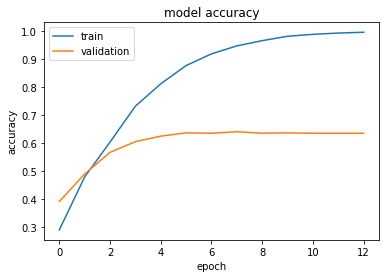

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

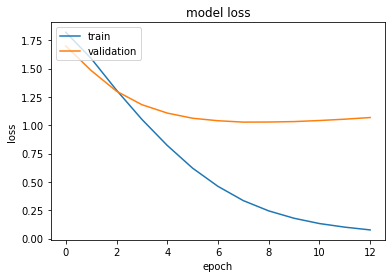

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

As it appears we were able to reach 64% accuracy on the validation set. The accuracy on the training set on the other hand was at 100% which is a clear sign that our model overfitted on the training dataset and was not able to generalize well, thus firing the early callback and stopping the training process at 15 epochs. Some possible reasons of that matter could be the fact that our model was not able to catch the true semantic meaning of the tweets or our dataset was just too small making our model incapable of learning.

In [ ]:
score = model.evaluate(test_X, test_Y,
                       batch_size=batch_size, verbose=1)

2536/2536 [==============================] - 0s 20us/step


In [ ]:
score[1]

0.6328864357072849

After evaluating the keras model n the test dataset the accuracy score is around 63%.

In [ ]:
score_bin = score_bin.append(pd.Series([14, 'Neural Network', score[1]], index=score_bin.columns), ignore_index=True)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

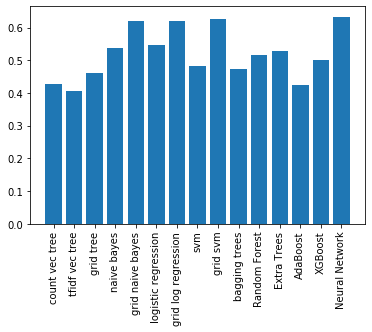

In [ ]:
plt.bar(list(score_bin.iloc[:, 1]), list(score_bin.iloc[:, 2]))
plt.xticks(rotation = 90)

As it appears the Neural Network model was able to achive greater accuracy on the test set, following the SVM model after grid search, the Naive Bayes after grid search and the logistic regression after grid search.

## Further Research

In order to achieve bette results a possible next step would be to download GLOVE embedings and retrain them to better suit the data. I more complex Neural network could be fitted using Convolutional Layers and LSTM Layers to better catch the semantic meaning of the tweets. Also since neural networks require a lot of data to be trained since they have much more parameters that classic machine learning models, an oversampling technique could be used in the training data only (SMOTE package). Apart from that ensembling between models that perfom their best on different classes may produce a model that could generalize better and achieve a more accurate classification.